## Loading up packages

### Step 1
Activate the Plastid conda environment and open up a Jupyter Lab session (alternatively, a python file can be run in this python environment)

### Step 2
Load in all of the necessary Python packages.

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy

In [3]:
# Define the path to our data files and the path we want to save our outputs in. 
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/human/'
counts_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/human/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/human/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/human/'
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
mutation = 'Larp1'
samp_num = '2'

# figure out if the notebook has already been done for this dataset and only run the
# visualizations. 
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

### Step 3
Load in the count arrays for one sample of your mutant data and one sample of your control data. 

In [4]:
# Load in the count positions data.
data_mutant, names_mutant = kat.load_count_positions(mutation+"_"+samp_num+"_counts.csv",counts_path)
data_control, names_control = kat.load_count_positions("control_"+ samp_num +"_counts.csv",counts_path)

### Step 4
filter out any count arrays that are of insufficient length or have insufficient read density. We filtered out count arrays which were under a hundred codons in length and which had a read density below 0.5 reads per codon, but the best filtering parameters will vary based on the quality of the data and the genome of the organism of study. Save the Gene ID's for the filtered count arrays into a list. 

In [5]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
mutant_list = []
control_list = []
gene_list = []
for tr_m, tr_c, gene_name in zip(data_mutant, data_control, names_mutant):
    if len(tr_m) > 100 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5:
        mutant_list.append(tr_m)
        control_list.append(tr_c)
        gene_list.append(gene_name)

### Step 5
Smooth out the count arrays using Loess smoothing and calculate the cumulative read distributions. the get_smoothed_vector() function from the keegan_analysis_tools python file is set up to perform Loess smoothing with a window size equal to 5% of the transcript length and calculates the cumulative read distribution. This step can take some time so it is recommended to use the multiprocess.Pool() function to complete this using multiple cores. 

In [6]:
max_pool = 20

# get smoothed vector arrays for all of the control data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_control = list(
            tqdm(
                p.imap(kat.get_smoothed_vector,
                       control_list),
                total=len(control_list)
            )
        )    

In [7]:
# get smoothed vector arrays for all of the mutant data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_mutant = list(
            tqdm(
                p.imap(kat.get_smoothed_vector,
                       mutant_list),
                total=len(mutant_list)
            )
        )    

### Step 6
For each gene in your mutant and control samples, calculate the KS-statistic as the maximum distance between their cumulative distributions and then save this KS-statistic as a list. 

In [8]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    len_list = []
    for tr_m, tr_c, index in zip(mutant_list, control_list, list(range(len(mutant_list)))):
        position = np.array(list(range(len(tr_m))))
        smoothed_vec_m, cumul_m = pool_mutant[index]
        smoothed_vec_c, cumul_c = pool_control[index]
        ks = max(abs(cumul_m - cumul_c))
        ks_list.append(ks)
        len_list.append(len(tr_m))

### Step 7
Combine the lists for the gene IDs, gene lengths, and KS statistics into a pandas dataframe using the pd.DataFrame, list() & zip() functions and save the resulting dataframe as a csv file using df.to_csv(). 

In [9]:
if pre_load == False:    
    # reorganizing the lists into a dataframe. 
    df_b = pd.DataFrame(list(zip(gene_list, ks_list, len_list)))
    df_b.columns = ["gene_ID", "ks_stat", "gene_length"]
    df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

In [10]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df_b = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

### Step 8
It is helpful to view the KS statistic from all of the control-mutant comparisons to see if any genes/transcripts have above average KS stats. Sort the KS values from smallest to largest using the sorted() function and then plot them as a scatter plot.

(0.0, 0.7)

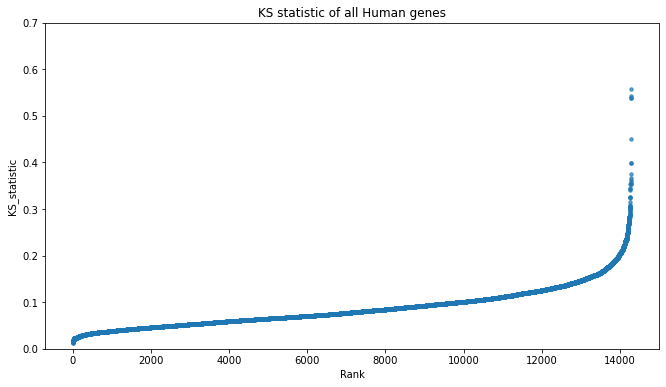

In [11]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(df_b["ks_stat"]))), sorted(df_b["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all Human genes")
plt.ylim(0,0.7)

### Step 9 
Create a new column in the table of KS values called size_groups which will contain a number from 1-3 based on the size/length of the transcript. Then, use pandas groupby() function to group the table of KS values by the values within the size_groups column. 

In [12]:
# Create a column in the data frame containing the size group for each gene.
size_groups = []
for i in df_b["gene_length"]:
    if i < 220:
        size_groups.append(1)
    elif i >= 220 and i < 600:
        size_groups.append(2)
    elif i >= 600:
        size_groups.append(3)
df_b["size_groups"] = size_groups

### Step 10 
Looking at the original count arrays of the genes with the highest KS values is a good way to determine if the KS statistic is actually picking up on elongation limitation or if the high KS statistics are just the result of random noise. Graph all of the count arrays for genes that have a KS statistic above a certain threshold and are within a certain size group. This can be done easily using the big_dif() function that can be found within the organization tools file. 

In [13]:
# Find all of the transcripts with a KS stat above a certain threshold and group them by gene ID
group = df_b[(df_b['ks_stat'] > 0.24) & (df_b['size_groups'] == 2)].groupby('gene_ID')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [14]:
len(diff_dist)

18

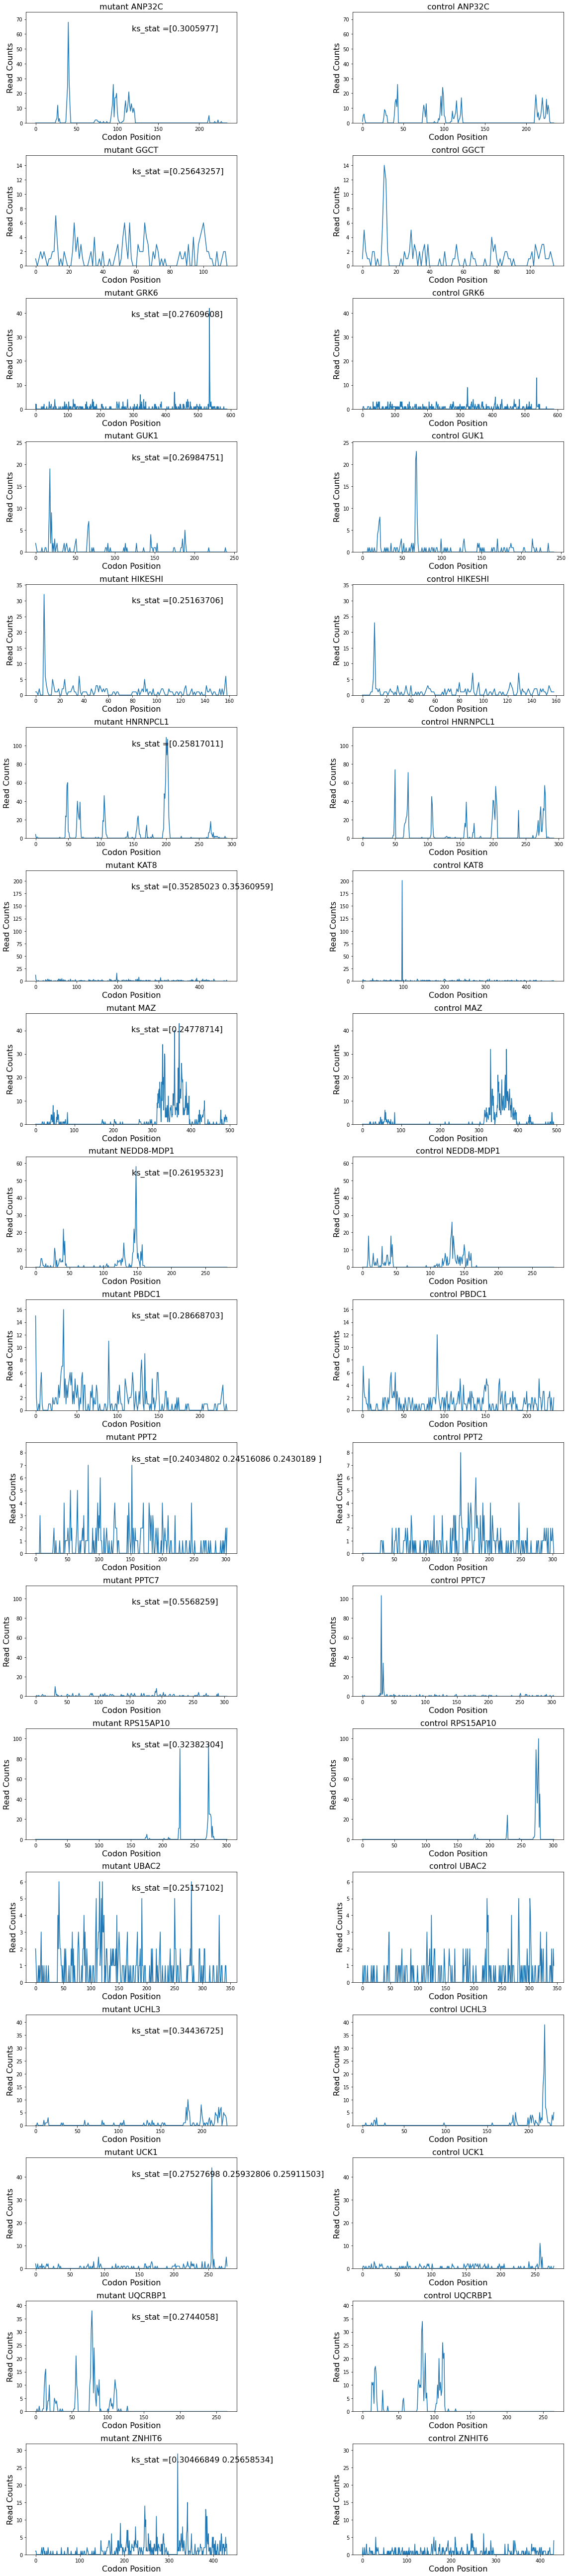

In [15]:
# Look at the smoothed count distributions for each of the transcripts that passed the threshold
ax = kat.big_dif(diff_dist, gene_list, mutant_list, control_list, figsize = (16,len(diff_dist)*4), fontsize = 16)

## Choose a gene of interest and observe the smooth and unsmooth array.

In [16]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_gene = 'VIM'
my_vec_mutant = None
my_vec_control = None
for tr_m, tr_c, name in zip(data_mutant, data_control, names_mutant):
    if name == my_gene:
        my_vec_mutant = tr_m
        my_vec_control = tr_c
if my_vec_mutant.any() == None:
    print("No gene found")

In [17]:
df_b[df_b["gene_ID"] == "VIM"]

,gene_ID,ks_stat,gene_length,size_groups
1602,VIM,0.050055,467,2


In [18]:
len(my_vec_mutant)

467

In [19]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_vec_control+0.00000000001)

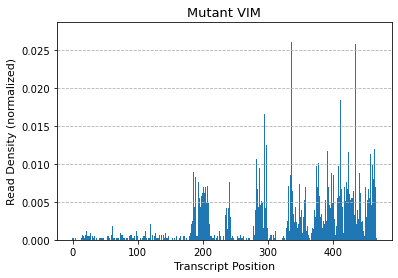

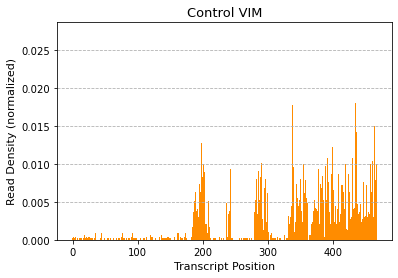

In [24]:
maxi = max([max(my_vec_mutant/sum(my_vec_mutant)), max(my_vec_control/sum(my_vec_control))])

plt.bar(list(range(len(my_vec_mutant))),my_vec_mutant/sum(my_vec_mutant), width = 1.4)
plt.ylim([0,maxi*1.1])
plt.ylabel("Read Density (normalized)", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Mutant " + my_gene, fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_mutant_array.pdf')
plt.show()
plt.bar(list(range(len(my_vec_mutant))), my_vec_control/sum(my_vec_control), color = "darkorange", width = 1.4)
plt.ylim([0,maxi*1.1])
plt.ylabel("Read Density (normalized)", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Control " + my_gene, fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_control_array.pdf')

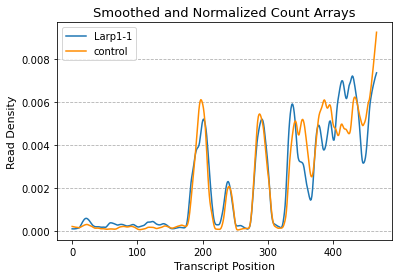

In [25]:
plt.plot(smoothed_vec_m, label = "Larp1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "control", color = "darkorange")
plt.ylabel("Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Smoothed and Normalized Count Arrays", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene +'_smoothed.pdf')

In [26]:
ks = max(abs(cumul_m - cumul_c))

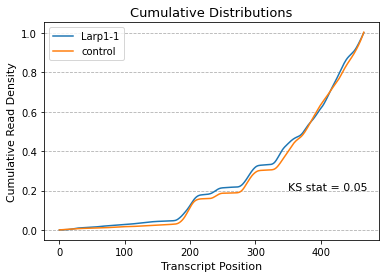

In [27]:
plt.plot(cumul_m, label = "Larp1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(cumul_c, label = "control")
plt.text(len(cumul_m)*0.75, 0.2, "KS stat = " + str(round(ks,3)), fontsize = 11)
plt.ylabel("Cumulative Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Cumulative Distributions", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_cumulative.pdf')